# New York Subway  Passengers Flow Analysis & Forecasting

<br>

## Autor: Sandro Saorin

<br>

## 1. Descrição do Projeto

<br>

O objetivo deste projeto será uma análise sobre as bases de dados sobre o fluxo de passageiros no metrô de New York, entender e avaliar o comportamento dos usuários dentro das vias e desenvolver uns algoritmos para predizer o fluxo de passageiro.

<br><br>

## 2. Metadados (Descrição sobre os Dados)

<br>

Os _datasets_ para análise são em um total 8 conjuntos de dados, separados por anos entre 2010 e 2017, Os metadados (ou seja, a descrição dos dados) será descrita nos itens abaixo:

<br>

__CA__ = sigla para _Control Area_, Área de Controle;

__UNIT__ = Unidade remota para uma estação; 

__SCP__ = sigla para _Subunit Channel Position_ representando o endereço de posição de um aparelho na estação; 

Subunit Channel Position represents an specific address for a device (02-00-00)

__STATION__ = Nome da estação de metrô; 

__LINENAME__ = Representa todas as linhas que desembarcam em determinada estação (representado por uma letra ou número). __Obs.:__ No caso específico da linha `456NQR` representa os trens 4, 5, 6, N, Q e R;

__DIVISION__ = Representa a linha em que a estação pertence;

__DATE__ = Marcação de Data e hora da extração do dados (MM-DD-YY hhmmss);

__DESC__ = Caracteriza o evento de análise dos passageiros. Quando identificado como `REGULAR` siginifica que a extração foi planejada (ocorrendo a cada 4 horas). Demais marcações tem características específicas sobre outros tipos de ocorrência para a extração;

__ENTRIES__ = Valor acumulado dos registro de entrada de um determinado aparelho;

__EXIST__ = Valor acumulado dos registro de saída de um determinado aparelho.

<br><br>

## 3. Análise Exploratória dos Dados

<br>

Como critério para realizar a análiseexploratória dos dados, será considerada inicialmente apenas a base de dados do ano de 2017, por ser a base mais recente de informações (pois assim como outros países, normalmente ocorrem obras de revitalização e expansão de estações da linha de metrô) e por uma limitação de _hardware_ para a execução. No _Forecasting_ será reavaliado a necessidade de considerar as demais bases ou não.

Começando por carregar a base de dados do metrô de New York para o ano de 2017:

In [1]:
# Bibliotecas para a EDA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import datetime as dt

# Desativando eventuais warnings
pd.options.mode.chained_assignment = None

In [2]:
# Carrega a base de dados de 2017
mta2017 = pd.read_csv('2017.csv.gz',         # Nome da base de dados
                      compression = 'gzip',  # Tipo de compressão dos dados
                      header = 0,            # Posição do cabeçalho da tabela
                      sep = ',')             # Tipo de separador

Após carregar os dados, alguns pontos bem importantes a se fazer são dar uma olhada geral nos dados (normalmente utilizando da função `head` do _Pandas_), avaliar a estrutura dos dados (e eventuais problemas de variável), além de avaliar também problemas com valores faltantes:

In [3]:
# Visualização das primeira linhas
mta2017.head()

,time,ca,unit,scp,station,linename,division,desc,entries,exits
0,2017-01-01 00:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,5992418.0,2028543.0
1,2017-01-01 00:00:00,A002,R051,02-00-01,59 ST,NQR456W,BMT,REGULAR,5475502.0,1204841.0
2,2017-01-01 00:00:00,A002,R051,02-03-00,59 ST,NQR456W,BMT,REGULAR,842188.0,3132405.0
3,2017-01-01 00:00:00,A002,R051,02-03-01,59 ST,NQR456W,BMT,REGULAR,123036.0,218034.0
4,2017-01-01 00:00:00,A002,R051,02-03-02,59 ST,NQR456W,BMT,REGULAR,5210075.0,7206414.0


In [4]:
# Usando a função .info para olhar a estrutura do Dataframe
mta2017.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7466025 entries, 0 to 7466024
Data columns (total 10 columns):
 #   Column    Dtype  
---  ------    -----  
 0   time      object 
 1   ca        object 
 2   unit      object 
 3   scp       object 
 4   station   object 
 5   linename  object 
 6   division  object 
 7   desc      object 
 8   entries   float64
 9   exits     float64
dtypes: float64(2), object(8)
memory usage: 569.6+ MB


In [5]:
# Avaliando se existem eventuais valores faltantes
mta2017.isna().sum()

time        0
ca          0
unit        0
scp         0
station     0
linename    0
division    0
desc        0
entries     0
exits       0
dtype: int64

Das primeiras análises, observa-se que aparentemente não existe problemas nos dados no que tange a extração e carregamento dos dados (todas as variáveis estão com os tipos corretos e sem problemas de preenchimento). Ao que foi entendido pelo enunciado, os registros com maior normalidade e frequência são os que a variável `desc` está registrada como `REGULAR`. Dessa forma, a análise exploratória dos dados será focada apenas neste filtro e depois descartada a variável `desc`:

In [6]:
# Filtrando apenas os dados com descrição regular
mta2017Filter = mta2017[mta2017['desc'] == 'REGULAR']

Inicialmente, será utilizado uma visão diária para a análise dos dados. Portanto, deve-se criar uma nova variável nomeada como `data`, corrigindo o tipo de variável para _datetime_ e utilizar apenas a data:

In [7]:
# Transformando a variável time em tipo datetime
mta2017Filter.loc[:, 'data'] = pd.to_datetime(mta2017Filter.loc[:, 'time'])

In [8]:
# Extraindo só a data e criando a variável data
mta2017Filter.loc[:, 'data'] = mta2017Filter.loc[:, 'data'].apply(lambda x: datetime.date(x))

In [9]:
# Convertendo a variável data em datetime também
mta2017Filter.loc[:, 'data'] = pd.to_datetime(mta2017Filter.loc[:, 'data'])

In [10]:
# Verificando os tipos das variáveis time e data, mantendo o time original
print("Variável time: ", mta2017Filter.dtypes.time, " | Variável data: ", mta2017Filter.dtypes.data)

Variável time:  object  | Variável data:  datetime64[ns]


In [11]:
# Viasualizando as mudanças
mta2017Filter.head()

,time,ca,unit,scp,station,linename,division,desc,entries,exits,data
0,2017-01-01 00:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,5992418.0,2028543.0,2017-01-01
1,2017-01-01 00:00:00,A002,R051,02-00-01,59 ST,NQR456W,BMT,REGULAR,5475502.0,1204841.0,2017-01-01
2,2017-01-01 00:00:00,A002,R051,02-03-00,59 ST,NQR456W,BMT,REGULAR,842188.0,3132405.0,2017-01-01
3,2017-01-01 00:00:00,A002,R051,02-03-01,59 ST,NQR456W,BMT,REGULAR,123036.0,218034.0,2017-01-01
4,2017-01-01 00:00:00,A002,R051,02-03-02,59 ST,NQR456W,BMT,REGULAR,5210075.0,7206414.0,2017-01-01


O sistema de monitoramento do metrô de New York aparenta ser um pouco complexo mas entende-se que ao avaliar uma estação, deve-se avalair agregando as informações de `station`, `ca`, `unit` e `scp` por representarem subdivisão de uma própria estação. Aliás os dados estão na forma __cumulativa__, então a partir deste agrupamento pega-se os valores máximos e mínimos para o agrupamento das entradas e saídas, para ter-se apenas a __diferença diária__:

In [12]:
# Define as colunas que entram no GroupBy
groupby_cols = ['station', 'ca', 'unit', 'scp', 'data']

## Calcula a diferença de entradas diaria
mta2017In  = mta2017Filter.groupby(groupby_cols).entries.max() - mta2017Filter.groupby(groupby_cols).entries.min()
mta2017Out = mta2017Filter.groupby(groupby_cols).exits.max() - mta2017Filter.groupby(groupby_cols).exits.min()

## Reseta os indices
mta2017In  = mta2017In.reset_index()
mta2017Out = mta2017Out.reset_index()

# Une as tabelas
mta2017InOut = pd.merge(mta2017In, 
                      mta2017Out, 
                      how = 'outer')

In [13]:
# Tabela de saída do agrupamento com as diferenças calculadas
mta2017InOut.head(10)

,station,ca,unit,scp,data,entries,exits
0,1 AV,H007,R248,00-00-00,2017-01-01,1720.0,2749.0
1,1 AV,H007,R248,00-00-00,2017-01-02,1308.0,1953.0
2,1 AV,H007,R248,00-00-00,2017-01-03,2571.0,3149.0
3,1 AV,H007,R248,00-00-00,2017-01-04,2304.0,3265.0
4,1 AV,H007,R248,00-00-00,2017-01-05,2857.0,3317.0
5,1 AV,H007,R248,00-00-00,2017-01-06,2945.0,3379.0
6,1 AV,H007,R248,00-00-00,2017-01-07,1751.0,2653.0
7,1 AV,H007,R248,00-00-00,2017-01-08,1278.0,2377.0
8,1 AV,H007,R248,00-00-00,2017-01-09,2542.0,2691.0
9,1 AV,H007,R248,00-00-00,2017-01-10,2690.0,3134.0


Serão criadas algumas variáveis auxiliar como por exemplo o dia da semana, fluxo de passageiro (ou seja, quantos entraram e quantos saíram):

In [14]:
## Criando a variavel diada semana e o index do dia dasemana
mta2017InOut.loc[:, 'dia_semana'] = mta2017InOut.loc[:, 'data'].dt.day_name()
mta2017InOut.loc[:, 'dia_semana_index'] = mta2017InOut.loc[:, 'data'].dt.weekday

# Crando a variável fluxo de passageiros
mta2017InOut.loc[:, 'fluxo'] = mta2017InOut.loc[:, 'entries'] + mta2017InOut.loc[:, 'exits']

In [15]:
# Dando uma olhada nas novas variáveis
mta2017InOut.head()

,station,ca,unit,scp,data,entries,exits,dia_semana,dia_semana_index,fluxo
0,1 AV,H007,R248,00-00-00,2017-01-01,1720.0,2749.0,Sunday,6,4469.0
1,1 AV,H007,R248,00-00-00,2017-01-02,1308.0,1953.0,Monday,0,3261.0
2,1 AV,H007,R248,00-00-00,2017-01-03,2571.0,3149.0,Tuesday,1,5720.0
3,1 AV,H007,R248,00-00-00,2017-01-04,2304.0,3265.0,Wednesday,2,5569.0
4,1 AV,H007,R248,00-00-00,2017-01-05,2857.0,3317.0,Thursday,3,6174.0


Dado que foi criado as variáveis, deve-se explorar para entender se estão fazendo sentido em relação ao conjunto de dados. Um primeiro ponto a se avaliar a as principais estatísticas destas variáveis. Será feito isto através do `describe`:

In [16]:
# Gera as principais estatísticas para as variáveis numéricas
mta2017InOut.describe()

,entries,exits,dia_semana_index,fluxo
count,1.241934e+06,1.241934e+06,1.241934e+06,1.241934e+06
mean,3.403332e+04,3.096556e+04,2.999593e+00,6.499888e+04
std,6.347377e+06,6.294877e+06,2.000089e+00,1.172728e+07
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.840000e+02,1.010000e+02,1.000000e+00,4.270000e+02
50%,5.790000e+02,3.540000e+02,3.000000e+00,1.104000e+03
75%,1.132000e+03,8.080000e+02,5.000000e+00,1.970000e+03
max,2.122193e+09,2.088503e+09,6.000000e+00,3.457563e+09


Note-se que existe alguma anomalia nas variáveis `entries` e `exits`, pois a maior parte da concentração dos dados (quando se fala do terceiro quartil) é da ordem de grande de 1000 pessoas/dia, mas tÊm-se uma média de passageiro da ordem de grandeza 30000 pessoas/dias e um desvio padrão muito maior ainda (ordem de grandeza em 6 milhões). Isto é um forte indicativo da presença de __valores discrepantes__ conhecidos como _Outliers_. 

Uma forma deavaliar isto é utilizando do gráfico de _Boxplot_:

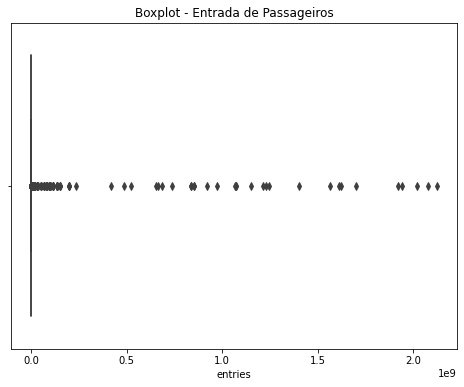

In [17]:
# Dimensiona a figura
plt.figure(figsize = (8,6))

# Cria um título
plt.title("Boxplot - Entrada de Passageiros")

# Gera o BoxPlot
sns.boxplot(data = mta2017InOut, 
            x = 'entries')

# Renderiza e plota na mesma célula
plt.show()

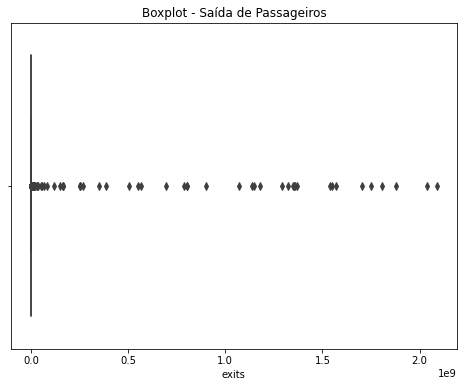

In [18]:
# Dimensiona a figura
plt.figure(figsize = (8,6))

# Cria um título
plt.title("Boxplot - Saída de Passageiros")

# Gera o BoxPlot
sns.boxplot(data = mta2017InOut, 
            x = 'exits')

# Renderiza e plota na mesma célula
plt.show()

Dado que foi confirmado estes _outliers_, deve-se filtrar estes valores e tentar entender se faz sentido com as condições da distribuição de dados ou não, antes mesmo de remover estes:

In [19]:
# Definindo os quartis, IQR e limite superior para as entradas
Q1Entries = np.quantile(mta2017InOut['entries'], 0.25)
Q3Entries = np.quantile(mta2017InOut['entries'], 0.75)
IQREntries = Q3Entries - Q1Entries
limSupEntries = 1.5*IQREntries + Q3Entries

# Definindo os quartis, IQR e limite superior para as saidas
Q1Exits = np.quantile(mta2017InOut['exits'], 0.25)
Q3Exits = np.quantile(mta2017InOut['exits'], 0.75)
IQRExits = Q3Exits - Q1Exits
limSupExits = 1.5*IQRExits + Q3Exits

# Print dos parâmetros
print('Entradas: ')
print("Q1            : ", Q1Entries)
print("Q3            : ", Q3Entries)
print("IQR           : ", IQREntries)
print("Lim. Superior : ", limSupEntries)
print(25*"=")
print('Saídas: ')
print("Q1            : ", Q1Exits)
print("Q3            : ", Q3Exits)
print("IQR           : ", IQRExits)
print("Lim. Superior : ", limSupExits)

Entradas: 
Q1            :  184.0
Q3            :  1132.0
IQR           :  948.0
Lim. Superior :  2554.0
Saídas: 
Q1            :  101.0
Q3            :  808.0
IQR           :  707.0
Lim. Superior :  1868.5


Agora deve-se filtrar as entradas e saídas de acordo com os limites superiores encontrados para encontrar os _outliers_:

In [20]:
# Criando o dataset somente os outliers
mta2017Outliers = mta2017InOut[(mta2017InOut.loc[:, 'entries'] >=limSupEntries) & (mta2017InOut.loc[:, 'exits'] >= limSupExits)]

Para avaliar os _outliers_, será utilizado como exemplo a estação `1 AV` para a análise:

In [21]:
mta2017Outliers[mta2017Outliers['station'] == '1 AV'].sort_values(by = ['ca', 'unit', 'scp', 'data'])

,station,ca,unit,scp,data,entries,exits,dia_semana,dia_semana_index,fluxo
2,1 AV,H007,R248,00-00-00,2017-01-03,2.571000e+03,3149.0,Tuesday,1,5.720000e+03
4,1 AV,H007,R248,00-00-00,2017-01-05,2.857000e+03,3317.0,Thursday,3,6.174000e+03
5,1 AV,H007,R248,00-00-00,2017-01-06,2.945000e+03,3379.0,Friday,4,6.324000e+03
9,1 AV,H007,R248,00-00-00,2017-01-10,2.690000e+03,3134.0,Tuesday,1,5.824000e+03
10,1 AV,H007,R248,00-00-00,2017-01-11,3.258000e+03,3257.0,Wednesday,2,6.515000e+03
...,...,...,...,...,...,...,...,...,...,...
260,1 AV,H007,R248,00-00-00,2017-09-18,2.632000e+03,3751.0,Monday,0,6.383000e+03
262,1 AV,H007,R248,00-00-00,2017-09-20,2.857000e+03,3725.0,Wednesday,2,6.582000e+03
384,1 AV,H007,R248,00-00-01,2017-04-29,2.568000e+03,1940.0,Saturday,5,4.508000e+03
451,1 AV,H007,R248,00-00-01,2017-07-05,3.628000e+03,2084.0,Wednesday,2,5.712000e+03


Note qu inexplicavelmente existe um salto nos registros de entradas e saídas como no exemplo para o último registro da tabela acima, onde a ordem de grandeza chega a ser 10 mil vezes maior (claramente indicando um problema de registro nos dados). Dessa forma, talvez pode-se flexibilizar um pouco mais o limite além dos _outliers_, pois podem ocorrer picos de registros devido a feriados e eventos, mas dentro de uma normalidade dos registros. Novamente deve-se avaliar os _outliers_ utiliando o `describe`:

In [22]:
# Gera as principais estatísticas para a base de outliers
mta2017Outliers.describe()

,entries,exits,dia_semana_index,fluxo
count,5.731000e+03,5.731000e+03,5731.00000,5.731000e+03
mean,6.844244e+06,5.930524e+06,2.49904,1.277477e+07
std,9.198521e+07,8.774111e+07,1.49477,1.690163e+08
min,2.554000e+03,1.869000e+03,0.00000,4.451000e+03
25%,2.788000e+03,2.128000e+03,1.00000,5.289500e+03
50%,3.160000e+03,2.503000e+03,3.00000,5.968000e+03
75%,3.741500e+03,3.304000e+03,4.00000,6.626000e+03
max,2.122193e+09,2.088503e+09,6.00000,3.457563e+09


Note que da mesma forma que anteriormente os _outliers_ são muito discrepantes e concentram boa parte dos dados no outro extremo. Dessa forma, pode mudar o limite seguramente para valores até 10 mil pessoas/dia que será removido os _outliers_ mais impactantes. Filtrando novamente os dados removendo todos maiores que 10 mil:

In [23]:
# Criando o dataset sem os outliers
mta2017InOutFilter = mta2017InOut[(mta2017InOut.loc[:, 'entries'] < 10000) & (mta2017InOut.loc[:, 'exits'] < 10000)]

In [24]:
# Avaliando as estatisticas novamente agora
mta2017InOutFilter.describe()

,entries,exits,dia_semana_index,fluxo
count,1.241407e+06,1.241407e+06,1.241407e+06,1.241407e+06
mean,7.610234e+02,5.807282e+02,2.999736e+00,1.341752e+03
std,7.412702e+02,6.979180e+02,2.000114e+00,1.181555e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.840000e+02,1.010000e+02,1.000000e+00,4.260000e+02
50%,5.790000e+02,3.530000e+02,3.000000e+00,1.103000e+03
75%,1.131000e+03,8.080000e+02,5.000000e+00,1.968000e+03
max,9.636000e+03,9.863000e+03,6.000000e+00,1.914600e+04


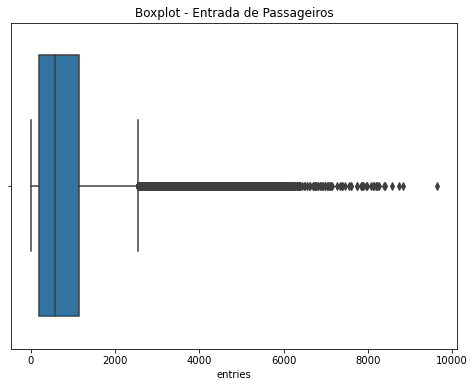

In [25]:
# Dimensiona a figura
plt.figure(figsize = (8,6))

# Cria um título
plt.title("Boxplot - Entrada de Passageiros")

# Gera o BoxPlot
sns.boxplot(data = mta2017InOutFilter, 
            x = 'entries')

# Renderiza e plota na mesma célula
plt.show()

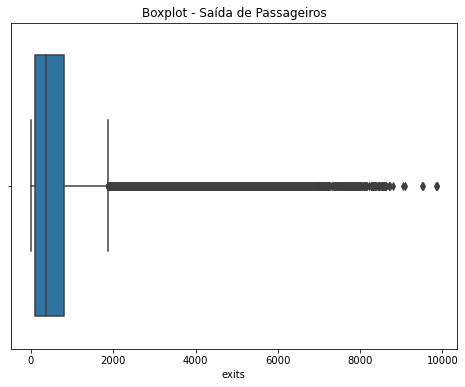

In [26]:
# Dimensiona a figura
plt.figure(figsize = (8,6))

# Cria um título
plt.title("Boxplot - Saída de Passageiros")

# Gera o BoxPlot
sns.boxplot(data = mta2017InOutFilter, 
            x = 'exits')

# Renderiza e plota na mesma célula
plt.show()

Pelos gráficos de _Boxplot_, houve uma melhora na visualização e na distribuição dos dados, mas dessa forma têm-se ago mais factível com a realidade do transporte do metrô de New York. Prosseguindo com as análises, agora será análise dos fluxos de passageiros a nível estação (variável `station`):

In [27]:
# calculando o número de estações
len(pd.unique(mta2017InOutFilter.loc[:, 'station']))

380

Olhando a nível estação, o metrô de New York têm cerca de 380 estações, o que para uma análise exploratória fico um pouco detalhado demais sem necessariamente chegar a grandes conclusões. Portanto, será utilizado para avaliar as principais estações com maior fluxo pelos dias da semana:

In [28]:
# Gerando os dados para as estações
mta2017Station = mta2017InOutFilter.groupby(['station', 'data', 'dia_semana_index', 'dia_semana']).sum().reset_index()

In [29]:
# Visualizando o novo dataframe
mta2017Station.head(10)

,station,data,dia_semana_index,dia_semana,entries,exits,fluxo
0,1 AV,2017-01-01,6,Sunday,11467.0,12935.0,24402.0
1,1 AV,2017-01-02,0,Monday,8130.0,9171.0,17301.0
2,1 AV,2017-01-03,1,Tuesday,13055.0,15337.0,28392.0
3,1 AV,2017-01-04,2,Wednesday,13977.0,16498.0,30475.0
4,1 AV,2017-01-05,3,Thursday,14570.0,17194.0,31764.0
5,1 AV,2017-01-06,4,Friday,15346.0,17260.0,32606.0
6,1 AV,2017-01-07,5,Saturday,12145.0,11355.0,23500.0
7,1 AV,2017-01-08,6,Sunday,8817.0,8023.0,16840.0
8,1 AV,2017-01-09,0,Monday,12312.0,13468.0,25780.0
9,1 AV,2017-01-10,1,Tuesday,13854.0,16921.0,30775.0


In [30]:
# Calculando a media por dia da semana
mta2017StationMean = mta2017Station.groupby(['station', 'dia_semana_index', 'dia_semana']).mean().reset_index()

# Ordenando pelos maiores fluxos 
mta2017StationMeanSort = mta2017StationMean.sort_values(by = ['dia_semana_index', 'fluxo'], ascending = False)

In [31]:
# Loop para printar as principais estações por dia da semana
for dia in range(0, 7):
    print(mta2017StationMeanSort[mta2017StationMeanSort['dia_semana_index'] == dia][['station', 'dia_semana', 'fluxo']].head(5))
    print(50*"=")

              station dia_semana          fluxo
427    34 ST-PENN STA     Monday  187737.447368
1631  GRD CNTRL-42 ST     Monday  166732.947368
413   34 ST-HERALD SQ     Monday  131995.605263
98     14 ST-UNION SQ     Monday  116535.052632
476   42 ST-PORT AUTH     Monday  114949.131579
              station dia_semana          fluxo
428    34 ST-PENN STA    Tuesday  202270.263158
1632  GRD CNTRL-42 ST    Tuesday  190268.500000
414   34 ST-HERALD SQ    Tuesday  145530.289474
323             23 ST    Tuesday  134119.026316
1583        FULTON ST    Tuesday  126791.473684
              station dia_semana          fluxo
429    34 ST-PENN STA  Wednesday  213412.026316
1633  GRD CNTRL-42 ST  Wednesday  201183.026316
415   34 ST-HERALD SQ  Wednesday  154754.473684
324             23 ST  Wednesday  144389.736842
100    14 ST-UNION SQ  Wednesday  135794.710526
              station dia_semana          fluxo
430    34 ST-PENN STA   Thursday  213971.684211
1634  GRD CNTRL-42 ST   Thursday  200824

Desta análise, é possível perceber que as principais estações utilizadas são:

<br>

34 ST-PENN STA <br>
GRD CNTRL-42 ST <br>
34 ST-HERALD SQ <br>
14 ST-UNION SQ <br>
42 ST-PORT AUTH <br>
23 ST <br>
FULTON ST <br>
TIMES SQ-42 ST <br>

<br>

Claro que muito depende do dia da semana a ser analisado, mas no gráfico abaixo será mostrado o fluxo médio de passageiros pelos dias da semana para a devida comparação:

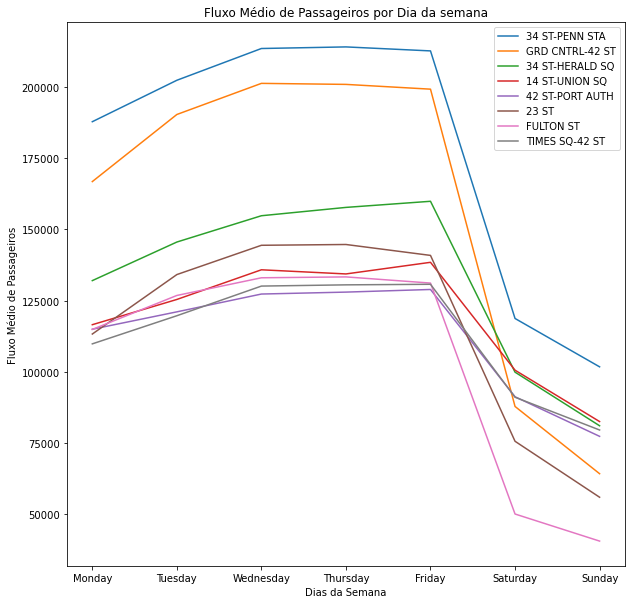

In [32]:
# Lista das principais estações
stations = ['34 ST-PENN STA',
            'GRD CNTRL-42 ST',
            '34 ST-HERALD SQ',
            '14 ST-UNION SQ',
            '42 ST-PORT AUTH', 
            '23 ST',
            'FULTON ST',
            'TIMES SQ-42 ST']

# Configura o tamanho da figura
plt.figure(figsize = (10, 10))

# Loop para criar os gráficos de linhas por estação
for station in stations:
    sns.lineplot(data = mta2017StationMean[mta2017StationMean['station'] == station],
                 x = 'dia_semana',
                 y = 'fluxo',
                 label = station)

# Cria um titulo para o Grafico
plt.title("Fluxo Médio de Passageiros por Dia da semana")

# Titulo para o eixo X
plt.xlabel('Dias da Semana')

# Titulo para o eixo y
plt.ylabel('Fluxo Médio de Passageiros')

# Legenda para o gráfico
plt.legend()

# Renderiza e plota o gráfico na célula
plt.show()

As principais estações lideram disparado com relação ao fluxo de passageiros, com algumas pequenas mudanças com o que diz respeito ao fim de semana, mas no geral todas as principais estações têm um comportamento até que bem parecido.

Por fim, será interessante avaliar o comportamento ao longo do histórico de dados disponível neste _dataset_. Utilizando como exemplo a estação `34 ST PENN STA`, para avaliar o comportamento histórico do fluxo:

In [33]:
pennStation = mta2017Station[mta2017Station['station'] == '34 ST-PENN STA'].loc[:, ['data', 'fluxo']]

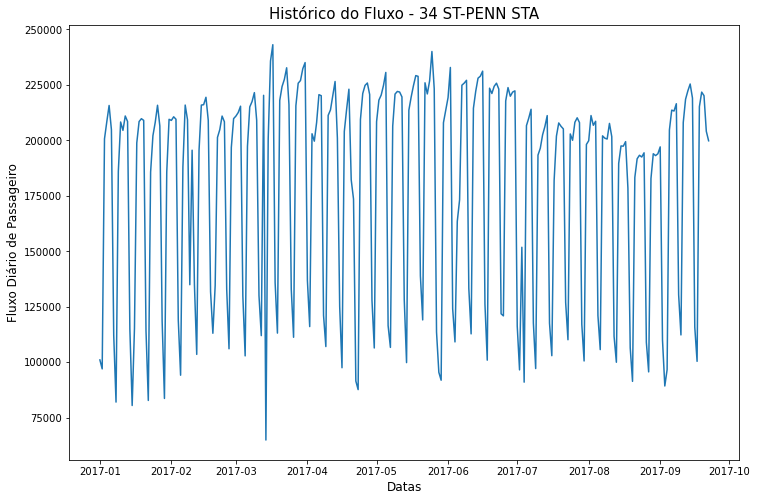

In [34]:
plt.figure(figsize = (12, 8))

# Plot da serie temporal
sns.lineplot(data = pennStation[pennStation['fluxo'] > 0],
             x = 'data',
             y = 'fluxo')

# Cria um titulo
plt.title('Histórico do Fluxo - 34 ST-PENN STA', fontsize = 15)

# Eixo X
plt.xlabel('Datas', fontsize = 12)

# Eixo y
plt.ylabel('Fluxo Diário de Passageiro', fontsize = 12)

# Mostra o gráfico
plt.show()

Note que ´evidente um comportamento cíclico no histórico diário de passageiros, motivado pelas diferenças de fluxo que ocorrem em dias úteis e finais de semana. Está é uma característica bem marcante e que corrobora para o bom funcionamento de modelos de _Forecasting_ a serem implementados no tópico a seguir.

## 

## Forecasting

<br>

Para o _Forecasting_ do fluxo de passageiros serão testados a iplementação em 2 algoritmos de _Machine Learning_ e Estatística com diferentes abordagens comforme descritas a seguir:

- __Modelo 1:__ Modelo de predição global do fluxo de passageiros utilizando o `auto_arima` e SARIMAX;

- __Modelo 2:__ Modelo de predição para as principais estações utilizando de Regressores como _RandomForest_ e _LightGBM_;

<br><br>

### Modelo 1 - Auto Arima e SARIMAX

<br>

Para o modelo que será utilizado com o Auto Arima e o SARIMAX (Modelo ARIMA com Sazonalidade), utilizará como critério tratar sobre o fluxo de passageiros de uma forma global, ou seja, a soma de todos os fluxos em todas as estações. Certamente este mesmo modelo pode ser inplementado para as principais estações ou todas as estações separadamente, mas pensando em um primeiro teste foi descartado essas opções.

Dessa forma, primeiro ponto é preparar o _dataset_ para o fluxo global de passageiros:

In [35]:
# Biblioteca para o  TIme Series / Forecasting
from pmdarima import auto_arima
import scipy.stats as ss
import statsmodels
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Ignora eventuais warnings
import warnings
warnings.filterwarnings('ignore')

In [36]:
# Sumarizando os fluxos por data e quantidade apenas
mta2017Global = mta2017Station[['data', 'fluxo']].groupby(['data']).sum().reset_index()

# Ajusta o indice como a data
mta2017Global.set_index('data', inplace = True)

# Configura o indice como data e com frequência diaria
mta2017Global.index = mta2017Global.index.to_period('D')

# Remove o ultimo elemento zerado (por causa de não tem com quem fazer a diferença)
mta2017Global = mta2017Global[mta2017Global['fluxo'] > 0]

In [37]:
# Visualização das primeiras linhas
mta2017Global.head()

,fluxo
data,
2017-01-01,3678822.0
2017-01-02,3546640.0
2017-01-03,6300888.0
2017-01-04,6882521.0
2017-01-05,7043574.0


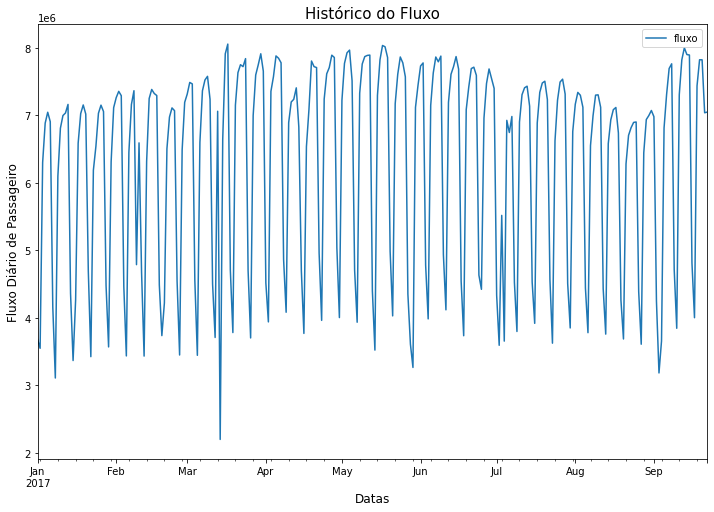

In [38]:
# Plot da serie temporal
mta2017Global.plot(figsize = (12,8))

# Cria um titulo
plt.title('Histórico do Fluxo', fontsize = 15)

# Eixo X
plt.xlabel('Datas', fontsize = 12)

# Eixo y
plt.ylabel('Fluxo Diário de Passageiro', fontsize = 12)

# Mostra o gráfico
plt.show()

As composições de séries temporais das estações têm um comportamento cíclico, mas não necessariamente estacionário, condição está necessária para poder fazer as predições para a série temporal. Para isto será feito uma avaliação visual com histograma e o gráfico Q-Q e um teste de hipótese de __Dicker-Fuller Aumentado__:

In [39]:
# Cria uma função para o histograma e o Q-Q plot
def dist_ts(ts, lab = '', bins = 40):
    # cria dois subplots lado a lado
    f, (ax1, ax2) = plt.subplots(1, 2, figsize = (7, 3))
    
    # Histograma com a label
    ts.hist(ax = ax1, bins = bins, alpha = 0.5)
    ax1.set_xlabel('Value')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Histograma de ' + lab)
    
    # Plot do gráfico Q-Q
    ss.probplot(ts, plot = ax2)

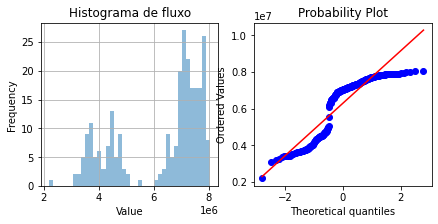

In [40]:
# Histograma e gráfico Q-Q para a categoria 1
dist_ts(mta2017Global['fluxo'], 'fluxo')

Percebe-se que a dritribuição tem uma caracteristica bem assimétrica com até a presença de duas distribuições distintas, devendo ser caracterizado pela diferença entre os fluxos dos dias da semana em relação ao fim de semana. Note, também que essa característica aparece no gráfico Q-Q, onde por mais que boa parte dos pontos estão próximos a linha que caracteriza a distribuição normal, no lado direito tem pontos que distoam bastantes, isto indica que o modelo terá dificuldades de aproximar por não ter uma caracteristica estacionária a distribuição.

Agora deve-se olhar para o teste de hipótese _Dicker-Fuller Aumentado_ que indicará explicitamente se a série temporal é estacionário ou não:

In [41]:
# Testando para os casos confirmados
y_conf = mta2017Global['fluxo'].values

# Teste de Dickey Fuller
result = adfuller(y_conf)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Cria a resposta de acordo com p value
if result[1] < 0.05:
    print('É Estacionário!')
else:
    print('Não é Estacionário!')

ADF Statistic: -2.844914
p-value: 0.052139
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
Não é Estacionário!


Certamente a série temporal não é estacionária, mas como será utilizado o SARIMAX junto com o Auto-Arima, o próprio modelo ajustará a série utilizando de diferenças.

O modelo conhecido do `statsmodels` como SARIMAX, seria um modelo ARIMA onde será considerado a sazonalidade. O modelo ARIMA é um modelo estatístico para Séries Temporais que compôe de 3 tipos de modelos para a caracterização da série:


- __Modelos Autoregressivos (AR):__ é a componente que leva em consideração a autocorrelação dos dados com eles mesmos quando levado em consideração flags (ou chamadas defasagens) no período de tempo dos dados;

- __Modelo Intergrativo (I):__ é a componente que leva em consideração a estacionariedade da série. Para ser possível fazer o Forecasting é necessário que a uma determinada série seja estacionária, e o modelo integrativo força este efeito pegando as diferenças da variável y entre ela mesma considerando també uma defasagem de tempo;

- __Modelo de Médias Móveis (MA):__ é a componente que faz o ponderamento dos dados de acordo com a média em uma janela de dias deslizante, ou seja, efeitos de picos e vales são atenuados ao longo da série devido a utilização da média.


Para determinar a melhor combinação de parâmetros para tanto o modelo ARIMA como a sanozalidade (efeito cíclico com intervalo de tempo bem definido), será utilizado a biblioteca `auto_arima` que testa diversas combinações e devolva a combinação que melhor de adequa ao conjunto de dados:

In [42]:
# Aplica o Auto Arima
stepwise_fit1 = auto_arima(mta2017Global['fluxo'], 
                          start_p = 0, 
                          start_q = 0,
                          max_p = 3, 
                          max_q = 3, 
                          m = 7,
                          seasonal = True,
                          trace = True,
                          error_action = 'ignore',   
                          suppress_warnings = True,  
                          stepwise = False)           

# Sumário do Auto Arima
stepwise_fit1.summary()

 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=8326.551, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=8233.025, Time=0.05 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=8198.546, Time=0.08 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=8169.182, Time=0.05 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=8144.107, Time=0.12 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=8146.058, Time=0.17 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=8154.251, Time=0.10 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=8145.986, Time=0.18 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=8147.171, Time=0.39 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=8328.043, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=8208.122, Time=0.15 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=8179.440, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=8147.251, Time=0.10 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=8128.427, Time=0.14 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=8130.390, Time=0.27 sec
 ARIMA(0,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  265
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 7)   Log Likelihood               -3976.231
Date:                             Mon, 26 Dec 2022   AIC                           7966.462
Time:                                     17:57:50   BIC                           7991.493
Sample:                                 01-01-2017   HQIC                          7976.520
                                      - 09-22-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.049e+04   1.67e+04      1.225      0.220   -1.23e+04    5.33e+04
ar.L1         -0.9730      0.103     -9.477      0.000      -1.174      -0.772
ma.L1          0.3469      0.136      2.552      0.011       0.081       0.613
ma.L2         -0.5834      0.114     -5.139      0.000      -0.806      -0.361
ar.S.L7        0.9758      0.020     48.300      0.000       0.936       1.015
ma.S.L7       -0.6850      0.096     -7.101      0.000      -0.874      -0.496
sigma2       1.08e+12   6.05e-05   1.79e+16      0.000    1.08e+12    1.08e+12
===================================================================================
Ljung-Box (L1) (Q):                   1.80   Jarque-Bera (JB):              1940.13
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               0.37   Skew:                            -2.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.03e+33. Standard errors may be unstable.
"""

In [43]:
# Gera o modelo SARIMAX
model = sm.tsa.statespace.SARIMAX(mta2017Global['fluxo'], 
                                  order = (1, 1, 2), 
                                  seasonal_order = (1, 0, 1, 7))

# Fit do Modelo
results = model.fit()

# Sumário do Modelo
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               fluxo   No. Observations:                  265
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 7)   Log Likelihood               -3965.539
Date:                             Mon, 26 Dec 2022   AIC                           7943.079
Time:                                     17:57:50   BIC                           7964.534
Sample:                                 01-01-2017   HQIC                          7951.700
                                      - 09-22-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5908      0.404      1.464      0.143      -0.200       1.382
ma.L1         -1.3023      0.423     -3.080      0.002      -2.131      -0.474
ma.L2          0.3235      0.399      0.810      0.418      -0.459       1.106
ar.S.L7        0.9949      0.010     99.384      0.000       0.975       1.015
ma.S.L7       -0.8674      0.124     -6.981      0.000      -1.111      -0.624
sigma2      1.081e+12   1.69e-12   6.38e+23      0.000    1.08e+12    1.08e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.63   Jarque-Bera (JB):              3838.72
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):               0.37   Skew:                            -2.71
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.58e+39. Standard errors may be unstable.
"""

Definida a melhor combinação de parâmetros para o SARIMAX (é note que para os parâmetros da série foi utilizado uma d = 1, ou seja, utilizou-se uma diferenciação, provavelmente para corrigir a falta de estacionariedade).

## 

### Validação do Modelo utilizando Splits de Diferentes Tamanhos

<br>

A validação do modelo será feita utilizando de splits (parttes) de diferentes tamanhos, ou seja, partindo do ponto inicial da série, será testado conjuntos de dados com diferentes quantidade de dados de maneira a ver progressivamente como se comporta o erro na predição desta seria, isto levando em consideração uma janela de validação de 21 dias.

Foi desenvolvido duas funções que fazem o o papel de gerar as separações, treinar o modelo, criar a predições e determinar o erro respectivamente:

In [44]:
# One-Step Sarima Forecast
def sarima_forecast(history, order, sorder):
    # Define o SARIMA
    model = sm.tsa.statespace.SARIMAX(history, 
                                      order = order, 
                                      seasonal_order = sorder
                                      )
    
    # Fit do Modelo
    model_fit = model.fit(disp=False)
    
    # Faz uma predição com o Sarima e retorna este valor
    yhat = model_fit.predict(len(history), len(history))
    
    # Retorna a predição
    return yhat[0]
 
# Função para fazer a validação com splits de diferentes comprimentos
def time_series_split(data, length, cv, window_val, order, sorder):
    # Define uma lista vazia para os erros
    list_errors = list()
    
    # Define o tamanho dos folds de acordo com o cv
    size_steps = int(length/cv)
    
    # Loop nos splits do dados
    for i in range(cv):
        # Define uma lista vazia para as predições
        predictions = list()
                
        # Separa os dados em treino e teste
        train = data[:(i + 1)*size_steps - window_val] 
        test = data[size_steps - window_val:size_steps]
        
        # cria o historico com os dados de treino
        history = [x for x in train]
        
        # Loop nos dados de teste para gerar as predições
        for j in range(len(test)):
            # Fit do modelo e gera a predição
            yhat = sarima_forecast(history, order, sorder)
            # salva as predições
            predictions.append(yhat)
            # atualiza o historico com o dado de teste atual
            history.append(test[j])
            
        # Calcula o MAPE para a iteração    
        errors = mean_absolute_percentage_error(test.values, predictions)
        # Salva o valor em uma lista de erros
        list_errors.append(errors)
    
    # Retorna os erros em cada um dos folds
    return list_errors

In [45]:
# Define a order e o seasonal_order de acordo com o auto_arima
order = (1, 1, 2)
seasonal_order = (1, 0, 1, 7)

# Utiliza a função para testar composições diferentes dos dados
errors = time_series_split(mta2017Global['fluxo'],
                           len(mta2017Global['fluxo']),
                           7,
                           21, 
                           order, 
                           seasonal_order)

In [46]:
# Mostra os erros cometidos
errors

[0.3045662194158694,
 0.18060233738049786,
 0.22698352741338954,
 0.16095390737737764,
 0.174709239723693,
 0.2429239964200767,
 0.23578740925103608]

Em média os erros de adequação da série estão baixos e satisfatórios, dessa forma o modelo está até que bem adequado para gerar predições.

Próximo passo será separar o histórico dos dados em treino e teste para treinar a série e gerar as predições:

In [47]:
# Separa os dados em treino e teste a partir de um tamanho de janela
window_size = 21

# Separa os dados de fato
train = mta2017Global.iloc[:-window_size]
test  = mta2017Global.iloc[-window_size:]

# Print dos Shapes
print('Quantidade total dos dados: ', mta2017Global.shape)
print('Dados para Treinamento:     ', train.shape)
print('Dados para Teste:           ', test.shape)

Quantidade total dos dados:  (265, 1)
Dados para Treinamento:      (244, 1)
Dados para Teste:            (21, 1)


In [48]:
# Define inicio e fim para as predições
start = len(train)
end   = len(train) + len(test) - 1

# Obtendo as predições
predicts = results.predict(start = start, 
                             end = end, 
                             dynamic = False, 
                             typ = 'levels').rename('Previsões')

# Ajustando o index das predições
predicts.index = test.index

In [49]:
# Vamos fazer um comparativo entre predito e esperado
for i in range(len(predicts)):
    print(f"predito = {predicts[i]:<6.4}, esperado = {test['fluxo'][i]:<6.4}")

predito = 4.377e+06, esperado = 4.247e+06
predito = 3.662e+06, esperado = 3.182e+06
predito = 6.219e+06, esperado = 3.655e+06
predito = 5.933e+06, esperado = 6.811e+06
predito = 6.783e+06, esperado = 7.306e+06
predito = 7.038e+06, esperado = 7.691e+06
predito = 7.09e+06, esperado = 7.761e+06
predito = 4.597e+06, esperado = 4.714e+06
predito = 3.797e+06, esperado = 3.843e+06
predito = 6.121e+06, esperado = 7.303e+06
predito = 7.162e+06, esperado = 7.819e+06
predito = 7.545e+06, esperado = 7.998e+06
predito = 7.597e+06, esperado = 7.898e+06
predito = 7.445e+06, esperado = 7.891e+06
predito = 4.804e+06, esperado = 4.811e+06
predito = 3.955e+06, esperado = 4e+06 
predito = 6.413e+06, esperado = 7.434e+06
predito = 7.379e+06, esperado = 7.821e+06
predito = 7.697e+06, esperado = 7.82e+06
predito = 7.664e+06, esperado = 7.036e+06
predito = 7.308e+06, esperado = 7.046e+06


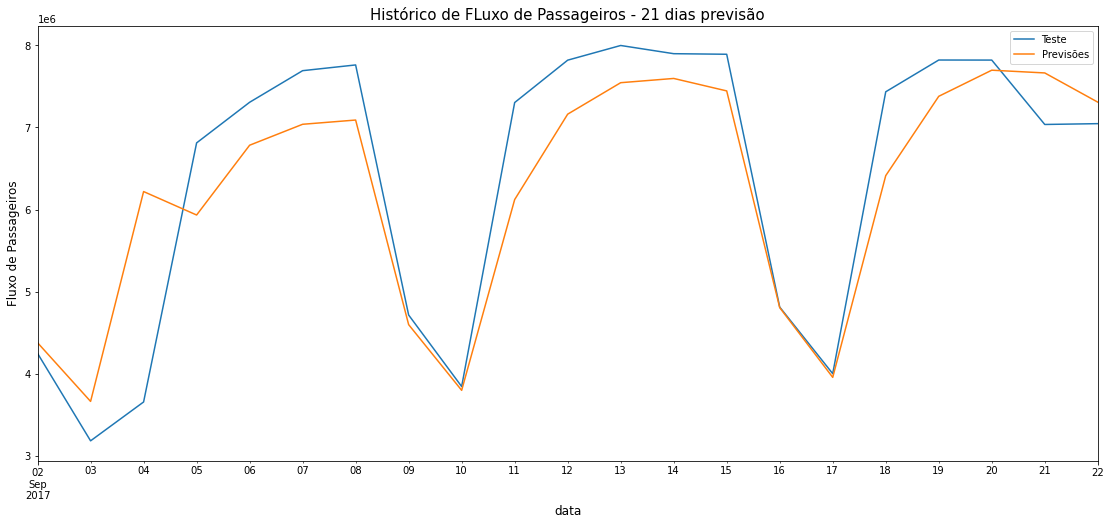

In [50]:
# Plot do Gráfico para os 21 dias
# Define o tamanho da figura
plt.figure(figsize = (19, 8))

# Define o titulo do gráfico
plt.title('Histórico de FLuxo de Passageiros - 21 dias previsão', fontsize = 15)

# Define os titulos de X e Y
plt.xlabel('Datas', fontsize = 12)
plt.ylabel('Fluxo de Passageiros', fontsize = 12)

# Cria os gráficos 
test['fluxo'].plot(legend = True, label = 'Teste')
predicts.plot(legend = True)

# Mostra o gráfico
plt.show()

O desempenho do modelo foi realmente bem satisfatório, no que tange a uma primeira versão para os fluxos globais de passageiros, onde ficaram bem próximas as aproximações. Para eventuais próximas versões, seria interessante avaliar o efeito das estações separadamente e depois gerar a composição de predições.

Para gerar novas predições, além dos dados tratados, segue o bloco de código a seguir:

In [51]:
# Definindo a nova janela de predições para 21 dias
start2 = len(mta2017Global)
end2   = len(mta2017Global) + 21

# Obtendo as  novas predições
new_predicts = results.predict(start = start2, 
                                 end = end2, 
                                 dynamic = False, 
                                 typ = 'levels').rename('Novas Previsões')

In [52]:
# visualiza as novas predições de 21 dias
new_predicts

2017-09-23    4.543505e+06
2017-09-24    3.827056e+06
2017-09-25    6.460193e+06
2017-09-26    7.140166e+06
2017-09-27    7.419555e+06
2017-09-28    7.364316e+06
2017-09-29    7.286281e+06
2017-09-30    4.624695e+06
2017-10-01    3.883889e+06
2017-10-02    6.487085e+06
2017-10-03    7.153823e+06
2017-10-04    7.426015e+06
2017-10-05    7.367644e+06
2017-10-06    7.287989e+06
2017-10-07    4.638754e+06
2017-10-08    3.901013e+06
2017-10-09    6.490549e+06
2017-10-10    7.153649e+06
2017-10-11    7.424311e+06
2017-10-12    7.366151e+06
2017-10-13    7.286851e+06
2017-10-14    4.651065e+06
Freq: D, Name: Novas Previsões, dtype: float64

## 

## Modelo 2 - RandomForestRegressor e LightGBMRegressor

<br>

A ideia nestes modelos é criar novas variáveis utilizando _Feature Engineering_, para servir de insumo e poder utlizar modelos mais robustos de _MAchine Learning_ como por exemplo o _RandomForest_ e o _LightGBM_, que são dois modelos de _Ensembles_ com ótimos desempenhos.

O primeiro passo novamente é preparar o _dataset_ para estes modelos:

In [53]:
# Biblotecas utilizadas para os modelos a seguir
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

In [54]:
# Filtrando apenas as principais estações
mta2017Principal = mta2017Station.query("station in ('34 ST-PENN STA', 'GRD CNTRL-42 ST', '34 ST-HERALD SQ', '14 ST-UNION SQ', '42 ST-PORT AUTH',  '23 ST', 'FULTON ST', 'TIMES SQ-42 ST')")

# Trazendo apenas a data, estação e o fluxo
mta2017Principal = mta2017Principal[['data', 'station', 'fluxo']]

# Ignorando o caso de fluxo zerado
mta2017Principal = mta2017Principal[mta2017Principal['fluxo'] > 0]

# Ordena pela data
mta2017Principal = mta2017Principal.sort_values(by = ['data'], ascending = True)

In [55]:
# Visualizando o dataset
mta2017Principal.head(20)

,data,station,fluxo
3724,2017-01-01,14 ST-UNION SQ,66548.0
59779,2017-01-01,FULTON ST,48186.0
18077,2017-01-01,42 ST-PORT AUTH,93911.0
16215,2017-01-01,34 ST-PENN STA,101022.0
92904,2017-01-01,TIMES SQ-42 ST,64983.0
15683,2017-01-01,34 ST-HERALD SQ,83657.0
12226,2017-01-01,23 ST,52568.0
61640,2017-01-01,GRD CNTRL-42 ST,71514.0
92905,2017-01-02,TIMES SQ-42 ST,75965.0
12227,2017-01-02,23 ST,54743.0


As variáveis `data` e `staton` também serviram como uso para os modelos, dessa forma será necessário convertê-las para uma forma categórica númerica. Será utilizada função `LabelEncoder` oriunda do _Scikit-Learn_:

In [56]:
# Instanciando a função do encoder
encoder = LabelEncoder()

In [57]:
# Convertendo as colunas para as labels
mta2017Principal.loc[:, 'data'] = encoder.fit_transform(mta2017Principal.loc[:, 'data'])
mta2017Principal.loc[:, 'station'] = encoder.fit_transform(mta2017Principal.loc[:, 'station'])

In [58]:
# Ordena pela data
mta2017Principal = mta2017Principal.sort_values(by = ['data', 'station'], ascending = True)

In [59]:
# Resultado do Label Encoder
mta2017Principal.head()

,data,station,fluxo
3724,0,0,66548.0
12226,0,1,52568.0
15683,0,2,83657.0
16215,0,3,101022.0
18077,0,4,93911.0


Como _Feature Engineering_ para estes modelos, será utilizados de _lags_ (ou seja, o valor referente ao dia anterior e a diferença em relação ao dia anterior). Como teste inicial para estes modelos, será utilizado de 3 _lags_:

In [60]:
# Copia o dataset original
mta2017FE = mta2017Principal.copy()

# Cria o primeiro lag e primeira diferença
mta2017FE['ultimo_dia_fluxo'] = mta2017FE.groupby(['station'])['fluxo'].shift()
mta2017FE['dif_ultimo_dia'] = mta2017FE.groupby(['station'])['ultimo_dia_fluxo'].diff()

# Cria o segundo lag e segunda diferença
mta2017FE['ultimo_2dias_fluxo'] = mta2017FE.groupby(['station'])['fluxo'].shift(2)
mta2017FE['dif_ultimo_2dias'] = mta2017FE.groupby(['station'])['ultimo_dia_fluxo'].diff(2)

# Cria o terceiro lag e terceira diferença
mta2017FE['ultimo_3dias_fluxo'] = mta2017FE.groupby(['station'])['fluxo'].shift(3)
mta2017FE['dif_ultimo_3dias'] = mta2017FE.groupby(['station'])['ultimo_dia_fluxo'].diff(3)

# Remove as linhas que ficaram com valores faltantes (devido ao lags)
mta2017FE = mta2017FE.dropna()

In [61]:
# Resultado para o Feature Engineering
mta2017FE.head(20)

,data,station,fluxo,ultimo_dia_fluxo,dif_ultimo_dia,ultimo_2dias_fluxo,dif_ultimo_2dias,ultimo_3dias_fluxo,dif_ultimo_3dias
3728,4,0,125399.0,104733.0,-4469.0,109202.0,32741.0,71992.0,38185.0
12230,4,1,134590.0,129396.0,16149.0,113247.0,74653.0,54743.0,76828.0
15687,4,2,156540.0,147491.0,12932.0,134559.0,66862.0,80629.0,63834.0
16219,4,3,215713.0,208396.0,7719.0,200677.0,111416.0,96980.0,107374.0
18081,4,4,119824.0,121993.0,1858.0,120135.0,45539.0,76454.0,28082.0
59783,4,5,123244.0,122109.0,6681.0,115428.0,72854.0,49255.0,73923.0
61644,4,6,194297.0,185222.0,12624.0,172598.0,132263.0,52959.0,113708.0
92908,4,7,122634.0,119792.0,16132.0,103660.0,43827.0,75965.0,54809.0
3729,5,0,127548.0,125399.0,20666.0,104733.0,16197.0,109202.0,53407.0
12231,5,1,130354.0,134590.0,5194.0,129396.0,21343.0,113247.0,79847.0


Para entender se os modelos estão performando bem será utilizado de uma métrica de avaliação para isto. Para modelos de _Forecasting_, será utilizado da métrica _Root Mean Squared Log Error_, que representa o erro quadrático médio do log do valor real e predito, tirada a raíz posteriormente. Está métrica funciona bem como uma aproximação do error percentual cometido entre o modelo e o resultado real e ajuda a entender na evolução do nosso modelo.

Definindo a função para o cálculo do _Root Mean Squared Log Error_:

In [62]:
# Função ára definir a metrica
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

Como o retorno da métrica é um erro percentual, sempre que trabalha-se com erros é importante ter uma referência (também chamado em inglês de _Baseline_) para o comparativo dos modelos propostos. O _baseline_ utilizado neste caso é que a predição seja o próprio valor do dia anterior de fluxo:

In [63]:
# Cria uma lista vazia para armazenar os erros
mean_error = []

# Define um loop para fazer a validação do baseline
# Aqui está considerando a partir de 90% de dados para treino
for dia in range(237, 263):
    # Separa a base de treinamento
    train = mta2017FE[mta2017FE['data'] < dia]
    
    # Separa a base de validação
    val = mta2017FE[mta2017FE['data'] == dia]
    
    #define a predição
    y_pred = val['ultimo_dia_fluxo'].values
    
    # Calcula o erro
    error = rmsle(val['fluxo'].values, y_pred)
    
    # Print do erro para o determinado dia
    print('Dia %d - Erro: %.5f' % (dia, error))
    
    # Armazena o erro do dia para o calculo do erro medio
    mean_error.append(error)
    
# Devolve o valor do erro médio entre todos os dias testados    
print('Erro Médio : %.5f' % np.mean(mean_error))

Dia 237 - Erro: 0.57955
Dia 238 - Erro: 0.23171
Dia 239 - Erro: 0.72484
Dia 240 - Erro: 0.09786
Dia 241 - Erro: 0.02391
Dia 242 - Erro: 0.02572
Dia 243 - Erro: 0.03789
Dia 244 - Erro: 0.57951
Dia 245 - Erro: 0.28747
Dia 246 - Erro: 0.11058
Dia 247 - Erro: 0.74210
Dia 248 - Erro: 0.09071
Dia 249 - Erro: 0.03571
Dia 250 - Erro: 0.03395
Dia 251 - Erro: 0.54336
Dia 252 - Erro: 0.23732
Dia 253 - Erro: 0.70519
Dia 254 - Erro: 0.08179
Dia 255 - Erro: 0.03650
Dia 256 - Erro: 0.02439
Dia 257 - Erro: 0.02538
Dia 258 - Erro: 0.54762
Dia 259 - Erro: 0.21063
Dia 260 - Erro: 0.70131
Dia 261 - Erro: 0.05974
Dia 262 - Erro: 0.03329
Erro Médio : 0.26185


Agora, será rodado as mesma interações mas aplicado ao modelo de regressão _RandomForest_, onde este modelo baseia-se nos modelos de _Ensemble_ do tipo _Bagging_, onde combina a seleção aleatória de _features_ e geração massiva de árvores de predição:

In [64]:
# Cria uma lista vazia para armazenar os erros
mean_error = []

# Define um loop para fazer a validação do baseline
# Aqui está considerando a partir de 90% de dados para treino
for dia in range(237, 263):
    # Separa a base de treinamento
    train = mta2017FE[mta2017FE['data'] < dia]
    
    # Separa a base de validação
    val = mta2017FE[mta2017FE['data'] == dia]
    
    # Define os X e ys de treino e validação
    X_train, X_val = train.drop(['fluxo'], axis = 1), val.drop(['fluxo'], axis = 1)
    y_train, y_val = train['fluxo'].values, val['fluxo'].values
    
    # Define o modelo
    model = RandomForestRegressor(n_estimators = 1000, 
                                  n_jobs = -1, 
                                  random_state = 0)
    
    # Fit do Modelo
    model.fit(X_train, y_train)
    
    # Define a predição do modelo
    y_pred = model.predict(X_val)
    
    # Calcula o erro
    error = rmsle(y_val, y_pred)
    
    # Print do erro para o determinado dia
    print('Dia %d - Erro: %.5f' % (dia, error))
    
    # Armazena o erro do dia para o calculo do erro medio
    mean_error.append(error)
    
# Devolve o valor do erro médio entre todos os dias testados    
print('Erro Médio : %.5f' % np.mean(mean_error))

Dia 237 - Erro: 0.30846
Dia 238 - Erro: 0.13376
Dia 239 - Erro: 0.03895
Dia 240 - Erro: 0.05834
Dia 241 - Erro: 0.02161
Dia 242 - Erro: 0.05742
Dia 243 - Erro: 0.18588
Dia 244 - Erro: 0.16903
Dia 245 - Erro: 0.11826
Dia 246 - Erro: 0.67961
Dia 247 - Erro: 0.71646
Dia 248 - Erro: 0.05182
Dia 249 - Erro: 0.04234
Dia 250 - Erro: 0.10961
Dia 251 - Erro: 0.47761
Dia 252 - Erro: 0.07914
Dia 253 - Erro: 0.30787
Dia 254 - Erro: 0.07725
Dia 255 - Erro: 0.06249
Dia 256 - Erro: 0.07986
Dia 257 - Erro: 0.23259
Dia 258 - Erro: 0.10972
Dia 259 - Erro: 0.04402
Dia 260 - Erro: 0.12502
Dia 261 - Erro: 0.02829
Dia 262 - Erro: 0.02931
Erro Médio : 0.16710


O _RandomForestRegressor_ apresentou uma redução de cerca de 10% em relação ao modelo _baseline_, o que se mostrou um ótimo desenvolvimento. Fazendo um mesmo comparativo agora utilizando o _LightGBM_, modelo do tipo _Boosting_ baseado no erro entre as iterações durante a treinamento do modelo:

In [65]:
# Cria uma lista vazia para armazenar os erros
mean_error = []

# Define um loop para fazer a validação do baseline
# Aqui está considerando a partir de 90% de dados para treino
for dia in range(237, 263):
    # Separa a base de treinamento
    train = mta2017FE[mta2017FE['data'] < dia]
    
    # Separa a base de validação
    val = mta2017FE[mta2017FE['data'] == dia]
    
    # Define os X e ys de treino e validação
    X_train, X_val = train.drop(['fluxo'], axis = 1), val.drop(['fluxo'], axis = 1)
    y_train, y_val = train['fluxo'].values, val['fluxo'].values
    
    # Define o modelo
    model = LGBMRegressor(n_estimators = 1000, 
                          learning_rate = 0.01)
    
    # Fit do Modelo
    model.fit(X_train, y_train)
    
    # Define a predição do modelo
    y_pred = model.predict(X_val)
    
    # Calcula o erro
    error = rmsle(y_val, y_pred)
    
    # Print do erro para o determinado dia
    print('Dia %d - Erro: %.5f' % (dia, error))
    
    # Armazena o erro do dia para o calculo do erro medio
    mean_error.append(error)
    
# Devolve o valor do erro médio entre todos os dias testados    
print('Erro Médio : %.5f' % np.mean(mean_error))

Dia 237 - Erro: 0.30658
Dia 238 - Erro: 0.14555
Dia 239 - Erro: 0.05677
Dia 240 - Erro: 0.08276
Dia 241 - Erro: 0.02187
Dia 242 - Erro: 0.05419
Dia 243 - Erro: 0.18226
Dia 244 - Erro: 0.22560
Dia 245 - Erro: 0.12248
Dia 246 - Erro: 0.68729
Dia 247 - Erro: 0.36466
Dia 248 - Erro: 0.08177
Dia 249 - Erro: 0.03364
Dia 250 - Erro: 0.07691
Dia 251 - Erro: 0.47565
Dia 252 - Erro: 0.41800
Dia 253 - Erro: 0.37465
Dia 254 - Erro: 0.08013
Dia 255 - Erro: 0.02637
Dia 256 - Erro: 0.05540
Dia 257 - Erro: 0.12761
Dia 258 - Erro: 0.16062
Dia 259 - Erro: 0.12903
Dia 260 - Erro: 0.08312
Dia 261 - Erro: 0.02582
Dia 262 - Erro: 0.03833
Erro Médio : 0.17066


No caso do _LightGBM_, também teve uma redução significativa do erro em relação ao _Baseline_ mas ligeiramente menor do que o resultado obtido pelo _RandomForest_, mas ambos os modelos se mostraram bem poderosos no quesito predições com as técnicas utilizadas.

Como sugestão de próximos passos para melhorar ainda mais o desempenho destes modelos seria o refinamento na utilização de parâmetros ou mesmo criar novas outras _features_ para ajudar os modelos nas predições.

## 

## 4. Conclusão

Este projeto se mostrou bem interessante e desafiador, pois envolvia o profundo entendimento no que estava acontecendo nos dados. Sempre importante ressaltar que as tomadas de decisões e o que foi desenvolvido ao longo do projeto levou em consideração o nível de complexidade versus o tempo hábil para a entrega (neste particular exemplo ainda, está em meio a período de feriados), mas certamente algumas outras abordagens seja utilizandos diferentes outros modelos ou mesmo testando os modelos desenvolvido a nível estação servirão para enriquecer o estudo e aprofundar as análises.